### __- Importation des librairies__

In [47]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

<br>

### __*- Prétraitement des données pour le COVID-19 X-ray dataset*__   
* __Redimensionner toutes les images à la même taille (ex. 128x128).__

* __Normaliser les pixels entre 0 et 1.__

* __Diviser les données : ( 80% → Entraînement,  20% → Validation,  10% → Test)__

<br>

__*1. Redimensionner toutes les images à la même taille (128 x 128)*__

In [48]:
'''  Uniformiser toutes les images à la même taille '''

# Paramètres
IMG_SIZE = 128
BATCH_SIZE = 16
data_dir = "data/xray_dataset_covid19"


# Charger le dataset train
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=123,
    shuffle=True
)

# Charger le dataset test
test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=123
)


Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


<br>


__*2. Normaliser les pixels entre 0 et 1*__

In [49]:
# Référence
     # https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
     # Transformer les pixels de [0, 255] → [0, 1]

# Normalisation des données d’entrée
normalization_layer = tf.keras.layers.Rescaling(1./255)
full_train_ds = full_train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

<br>


__*3. Je divise par batches. Je prends 80% du dataset train pour l’entrainement et 20% pour la validation et le test set conserver séparément qui contient 30 % de la train set.*__

In [50]:
'''
   - Je prends 80% du dataset train pour l’entrainement 
   - J’ai pris les derniers 20% pour la validation
   - Je conserve le test set séparé qui contient 10% de données.
'''


AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000


full_train_ds = full_train_ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)


train_batches = tf.data.experimental.cardinality(full_train_ds).numpy()

# Calcul des parts : 80% train, 20% validation
val_batches = int(train_batches * 0.2)
train_batches = train_batches - val_batches

# Diviser le dataset train et validation
train_ds = full_train_ds.take(train_batches).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = full_train_ds.skip(train_batches).take(val_batches).cache().prefetch(buffer_size=AUTOTUNE)

print(f"✅ Train batches: {train_batches}, Validation batches: {val_batches}")
print(f"✅ Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")



✅ Train batches: 8, Validation batches: 2
✅ Test batches: 3


In [51]:
# Vérification des valeurs des pixels après normalisation
for images, labels in train_ds.take(1):
    img = images[0].numpy()
    print("Valeurs min de l'image en pixels :", img.min())
    print("Valeurs max de l'image en pixels :", img.max())
    print("Type de données (dtype)        :", img.dtype)

Valeurs min de l'image en pixels : 0.0
Valeurs max de l'image en pixels : 0.99908096
Type de données (dtype)        : float32


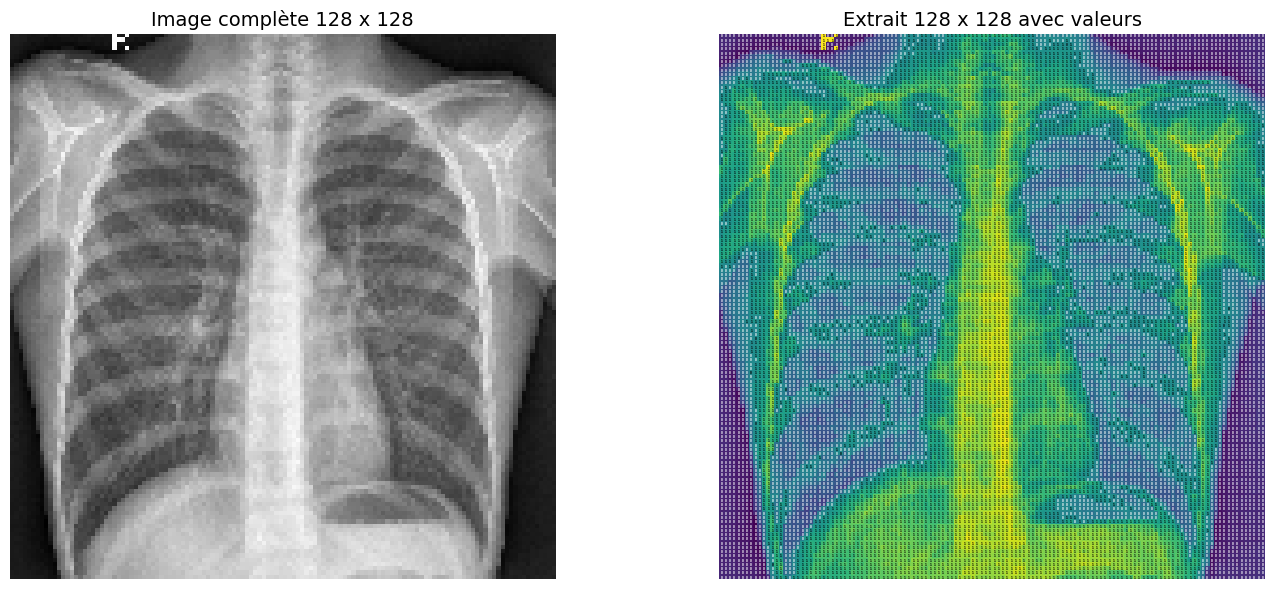

In [52]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in full_train_ds.take(1):
    img = images[0].numpy()
    gray = np.mean(img, axis=-1) if img.ndim == 3 else img.squeeze()

    # Extrait 128x128
    excerpt = gray[:128, :128]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Image complète
    ax1.imshow(gray, cmap='gray')
    ax1.set_title("Image complète 128 x 128", fontsize=14)
    ax1.axis('off')

    # Extrait 128x128 avec valeurs
    ax2.imshow(excerpt, cmap='viridis', interpolation='nearest')
    ax2.set_title("Extrait 128 x 128 avec valeurs", fontsize=14)
    ax2.axis('off')

    # Afficher les valeurs
    for i in range(128):
        for j in range(128):
            ax2.text(j, i, f"{excerpt[i,j]:.0f}",
                ha="center", va="center",
                color="white" if excerpt[i,j] < excerpt.max()/2 else "black",
                fontsize=2, fontweight='bold')

    plt.tight_layout()
    plt.show()
    break

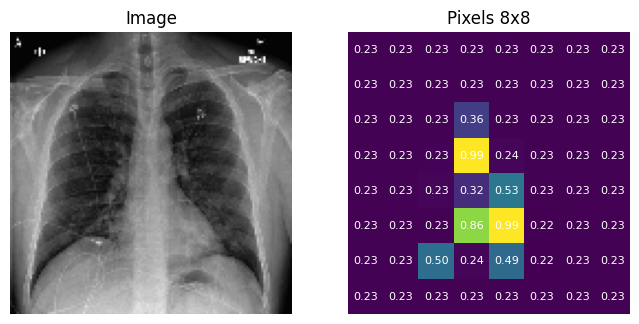

In [53]:
# Affichage d'une image et un extrait 8x8 pixels
for images, labels in train_ds.take(1):
    img = images[0].numpy()
    gray = img[:, :, 0] if img.ndim == 3 else img
    excerpt = gray[:8, :8]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(gray, cmap='gray'); ax1.set_title("Image"); ax1.axis("off")
    ax2.imshow(excerpt, cmap='viridis'); ax2.set_title("Pixels 8x8"); ax2.axis("off")

    for i in range(8):
        for j in range(8):
            ax2.text(j, i, f"{excerpt[i,j]:.2f}", ha='center', va='center', color='white', fontsize=8)

    plt.show()
    break


Affichage d'un batch de 16 images


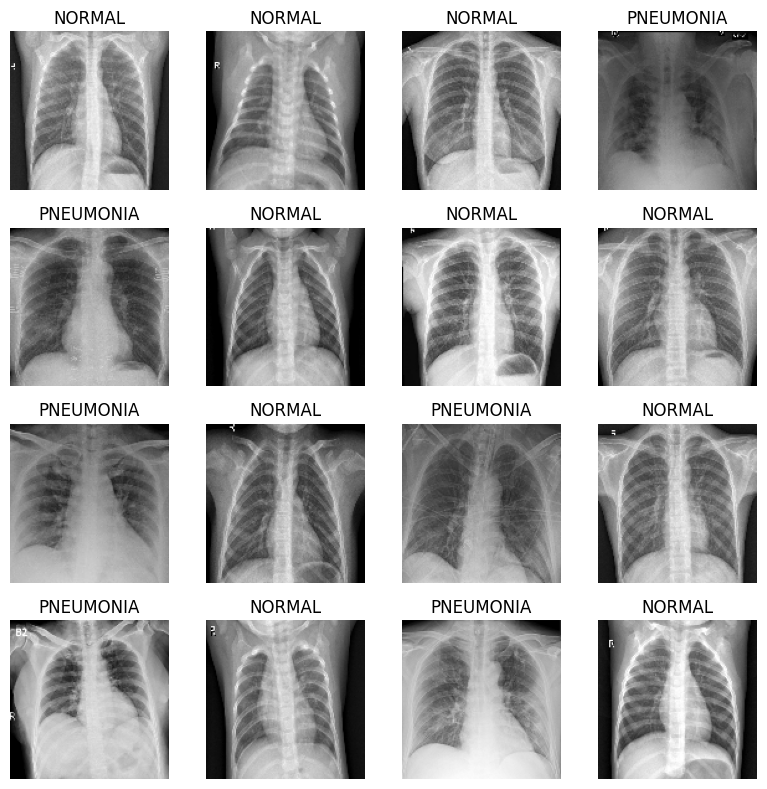

In [54]:
# Les notes :
    # index 0 : NORMAL
    # index 1 : PNEUMONIA



# Prendre un seul batch
for images, labels in train_ds.take(1):
    batch_size = images.shape[0]
    print(f"Affichage d'un batch de {batch_size} images")

    # Calculer le nombre de lignes et colonnes pour la grille
    cols = min(4, batch_size)
    rows = math.ceil(batch_size / cols)

    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(batch_size):
        img = images[i].numpy()

        if img.min() < 0:
            img = (img + 1) / 2
        elif img.max() > 1.0:
            img = img / 255.0

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title("NORMAL" if labels[i] == 0 else "PNEUMONIA")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

<br>
<br>


### __- Construction du modèle CNN__

In [55]:
# Référence pour le modèle CNN
    # https://www.youtube.com/watch?v=jDe5BAsT2-Y
    # https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80
    # https://victorzhou.com/blog/intro-to-cnns-part-1/
    # https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175

# Padding images cnn
    # https://learnopencv.com/understanding-convolutional-neural-networks-cnn/
    # https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175



import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


def covid_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=1):
    model = Sequential([
        Input(shape=input_shape),

        # Bloc Conv 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloc Conv 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloc Conv 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),


        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
        # sigmoid car c'est une classification binaire
    ])
    return model


In [56]:
# Référence  (ADAM)
    # https://en.wikipedia.org/wiki/Stochastic_gradient_descent
    # https://datasciencewiki.net/adam-optimisation/


model = covid_cnn_model()

# Compilation avec Adam et binary crossentropy
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Entraînement (commence avec 7 époques)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.4569 - loss: 1.2260 - val_accuracy: 0.5312 - val_loss: 0.6520
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7069 - loss: 0.6207 - val_accuracy: 0.7812 - val_loss: 0.5378
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8362 - loss: 0.4155 - val_accuracy: 0.8750 - val_loss: 0.3226
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8190 - loss: 0.3836 - val_accuracy: 0.8438 - val_loss: 0.2943
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9224 - loss: 0.2924 - val_accuracy: 0.9062 - val_loss: 0.2225


In [58]:

print("=== ÉVALUATION DU MODELE ===")

# 1. Précision globale
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss, val_acc = model.evaluate(val_ds, verbose=0)

print(f"✅ Précision sur train set : {train_acc:.2%}")
print(f"✅ Précision sur validation set : {val_acc:.2%}")
print(f"✅ Précision sur le test set : {test_acc:.2%}")

# 2. Rapport détaillé
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(((preds > 0.5).astype(int).flatten()).tolist())
    y_true.extend(labels.numpy().flatten().tolist())

print("\n📊 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'COVID']))

=== ÉVALUATION DU MODELE ===
✅ Précision sur train set : 92.24%
✅ Précision sur validation set : 90.62%
✅ Précision sur le test set : 100.00%

📊 Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00        20
       COVID       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [59]:
import threading
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf


def get_optimizers():
    return {
        'SGD': tf.keras.optimizers.SGD(),
        'RMSprop': tf.keras.optimizers.RMSprop(),
        'Adagrad': tf.keras.optimizers.Adagrad(),
        'Adam': tf.keras.optimizers.Adam(),
        'AdamW': tf.keras.optimizers.AdamW(),
        'Nadam': tf.keras.optimizers.Nadam()
    }


def train_parallel(train_ds, val_ds, test_ds, epochs):
    def train_one(name, optimizer):
        model = covid_cnn_model()
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0)
        _, test_acc = model.evaluate(test_ds, verbose=0)
        return name, {
            'train': history.history['accuracy'][-1],
            'val': history.history['val_accuracy'][-1],
            'test': test_acc
        }
    with ThreadPoolExecutor(max_workers=6) as ex:
        results_list = list(ex.map(lambda x: train_one(*x), get_optimizers().items()))

    return {name: metrics for name, metrics in results_list}


In [60]:

def print_results(results):
    print("\n" + "="*50)
    print("📊 RÉSULTATS")
    print("="*50)

    for name, m in sorted(results.items(), key=lambda x: x[1]['test'], reverse=True):
        print(f"{name:10s}: Train={m['train']:.2%}, Val={m['val']:.2%}, Test={m['test']:.2%}")


results = train_parallel(train_ds, val_ds, test_ds, epochs=10)
print_results(results)


📊 RÉSULTATS
SGD       : Train=78.45%, Val=84.38%, Test=100.00%
RMSprop   : Train=87.07%, Val=93.75%, Test=100.00%
Adam      : Train=97.41%, Val=100.00%, Test=100.00%
AdamW     : Train=97.41%, Val=96.88%, Test=100.00%
Nadam     : Train=95.69%, Val=96.88%, Test=100.00%
Adagrad   : Train=86.21%, Val=84.38%, Test=97.50%


In [61]:
def select_best_optimizer(results, overfitting_threshold=5.0):
    valid = {
        name: m for name, m in results.items()
        if m['train'] < 0.99 and abs(m['train'] - m['val']) * 100 <= overfitting_threshold
    }

    best = max((valid or results).items(), key=lambda x: x[1]['test'])[0]
    return best


# Utilisation
best_optimizer = select_best_optimizer(results)
print(f"Meilleur: {best_optimizer}")

Meilleur: Adam


In [62]:
# Sauvegarder dans un dossier spécifique
model.save('models/covid_model.h5')
print("✅ Modèle sauvegardé : models/covid_model.h5")



✅ Modèle sauvegardé : models/covid_model.h5
